In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

import csv
import time
from pandas import Grouper
from pandas import DataFrame
#from pandas.tools.plotting import lag_plot
#from pandas.tools.plotting import autocorrelation_plot
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from scipy.stats import itemfreq
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 20,5

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

Populating the interactive namespace from numpy and matplotlib


# Data Preparation

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(r'C:\Users\Asia\Desktop\Università\Magistrale\Data Mining\Dm 2\Progetto\Dataset\datatraining.csv', header=0, index_col='date', date_parser = dateparse )
#df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
rcParams['figure.figsize'] = 20,5

In [4]:
ts = df['Temperature']

In [5]:
len(ts)

8143

In [6]:
groups = ts.groupby(pd.Grouper(freq='6H'))
#groups.transform(lambda x: (x - x.mean()) / x.std())
groups.size()

date
2015-02-04 12:00:00      9
2015-02-04 18:00:00    360
2015-02-05 00:00:00    360
2015-02-05 06:00:00    360
2015-02-05 12:00:00    360
2015-02-05 18:00:00    360
2015-02-06 00:00:00    360
2015-02-06 06:00:00    360
2015-02-06 12:00:00    360
2015-02-06 18:00:00    360
2015-02-07 00:00:00    360
2015-02-07 06:00:00    360
2015-02-07 12:00:00    360
2015-02-07 18:00:00    360
2015-02-08 00:00:00    360
2015-02-08 06:00:00    360
2015-02-08 12:00:00    360
2015-02-08 18:00:00    360
2015-02-09 00:00:00    360
2015-02-09 06:00:00    360
2015-02-09 12:00:00    360
2015-02-09 18:00:00    360
2015-02-10 00:00:00    360
2015-02-10 06:00:00    214
Freq: 6H, Name: Temperature, dtype: int64

In [7]:
day = DataFrame()
for name, group in groups:
    #norm_values = ((group.values - mean(group.values)) / std(group.values))
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(group.values,(0,360-len(group.values)),'constant')
    day["0%s-0%s %s.0%s" %(name.month,name.day,name.hour,name.minute)] = pad_values

In [8]:
day = day.drop(['02-010 6.00'], axis=1)

In [9]:
day = day.drop(['02-04 12.00'], axis=1)

In [10]:
day.head()

,02-04 18.00,02-05 0.00,02-05 6.00,02-05 12.00,02-05 18.00,02-06 0.00,02-06 6.00,02-06 12.00,02-06 18.00,02-07 0.00,...,02-07 18.00,02-08 0.00,02-08 6.00,02-08 12.00,02-08 18.00,02-09 0.00,02-09 6.00,02-09 12.00,02-09 18.00,02-010 0.00
0,23.075,21.245,20.865000,22.2,22.000,20.2,20.290,21.675,21.7,20.0000,...,20.39,19.6,19.29,19.200,19.39,19.5,19.390,21.3900,22.075000,20.390000
1,23.075,21.245,20.890000,22.2,22.025,20.2,20.290,21.700,21.7,19.9725,...,20.39,19.6,19.29,19.200,19.34,19.5,19.445,21.4725,22.100000,20.356667
2,23.100,21.260,20.856667,22.2,22.000,20.2,20.290,21.700,21.7,20.0000,...,20.39,19.6,19.29,19.245,19.34,19.5,19.390,21.5000,22.100000,20.390000
3,23.100,21.245,20.890000,22.2,22.075,20.2,20.245,21.700,21.7,20.0000,...,20.39,19.6,19.29,19.245,19.29,19.5,19.390,21.5000,22.066667,20.390000
4,23.050,21.245,20.890000,22.2,22.025,20.2,20.245,21.700,21.7,20.0000,...,20.39,19.6,19.20,19.290,19.29,19.5,19.445,21.5000,22.100000,20.365000


In [11]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler.fit_transform(ts)

In [21]:
n_paa_segments = 20 #la trasformo in 20 segmenti
n_sax_symbols = 10 #usando 10 simboli divresi
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts) #applico la traformazione
sax_ts_inv = sax.inverse_transform(ts_sax) #questa è la trasformazione inversa

In [22]:
sax_ts_inv.ravel()

array([1.03643339, 1.03643339, 1.03643339, ..., 0.        , 0.        ,
       0.        ])

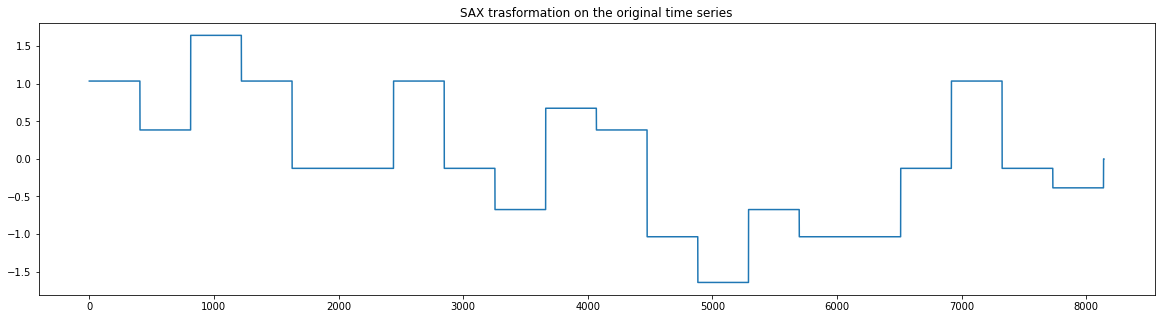

In [55]:
plt.plot(sax_ts_inv.ravel()) #plot della serie trasformata
plt.title('SAX trasformation on the original time series')
plt.show()

In [24]:
# faccio la mappa per trasformare ongi valore osservato nella serie in un simbolo
map_symbols = {k: v for v, k in enumerate(np.unique(sax_ts_inv.ravel()))}
map_symbols

{-1.6448536269514729: 0,
 -1.0364333894937898: 1,
 -0.6744897501960817: 2,
 -0.38532046640756773: 3,
 -0.12566134685507402: 4,
 0.0: 5,
 0.38532046640756773: 6,
 0.6744897501960817: 7,
 1.0364333894937898: 8,
 1.6448536269514722: 9}

In [25]:
seq = np.array([map_symbols[v] for v in sax_ts_inv.ravel()])

In [26]:
seq

array([8, 8, 8, ..., 5, 5, 5])

In [27]:
day = np.array(day)

In [28]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X = scaler.fit_transform(day)

In [29]:
n_paa_segments = 20 #la trasformo in 20 segmenti
n_sax_symbols = 10 #usando 10 simboli divresi
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

In [30]:
X_sax = sax.fit_transform(X)
sax_X_inv = sax.inverse_transform(X_sax)

In [48]:
sax_ts_inv.ravel()

array([1.03643339, 1.03643339, 1.03643339, ..., 0.        , 0.        ,
       0.        ])

In [31]:
X_seq = list()
for x in sax_X_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])

#e lo ha trasformato in un dataset di sequenze

In [32]:
X_seq

[[9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 0, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 0, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 7, 7, 2, 1, 9, 3, 1, 1, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 8, 8, 3, 3, 8, 7, 2, 2, 9, 3, 1, 0, 1, 1, 1, 1, 7, 5, 5],
 [9, 6, -1, 9, 8, 3,

In [36]:
from prefixspan import PrefixSpan

In [34]:
ps = PrefixSpan(X_seq)

In [50]:
ps.minlen = 3

In [51]:
ps.frequent(350)

[(360, [9, 2, 1]),
 (360, [9, 2, 1, 5]),
 (360, [9, 2, 1, 5, 5]),
 (360, [9, 2, 9]),
 (360, [9, 2, 9, 5]),
 (360, [9, 2, 9, 5, 5]),
 (360, [9, 2, 5]),
 (360, [9, 2, 5, 5]),
 (358, [9, 1, 1]),
 (358, [9, 1, 1, 5]),
 (358, [9, 1, 1, 5, 5]),
 (360, [9, 1, 5]),
 (360, [9, 1, 5, 5]),
 (360, [9, 9, 1]),
 (358, [9, 9, 1, 1]),
 (358, [9, 9, 1, 1, 5]),
 (358, [9, 9, 1, 1, 5, 5]),
 (360, [9, 9, 1, 5]),
 (360, [9, 9, 1, 5, 5]),
 (360, [9, 9, 5]),
 (360, [9, 9, 5, 5]),
 (360, [9, 5, 5]),
 (360, [2, 1, 5]),
 (360, [2, 1, 5, 5]),
 (360, [2, 9, 5]),
 (360, [2, 9, 5, 5]),
 (360, [2, 5, 5]),
 (358, [1, 1, 5]),
 (358, [1, 1, 5, 5]),
 (360, [1, 5, 5])]

In [52]:
ps.topk(20)

[(360, [2, 1, 5]),
 (360, [2, 1, 5, 5]),
 (360, [2, 9, 5]),
 (360, [2, 9, 5, 5]),
 (360, [9, 1, 5]),
 (360, [9, 1, 5, 5]),
 (360, [9, 2, 1]),
 (360, [9, 2, 1, 5]),
 (360, [9, 2, 1, 5, 5]),
 (360, [9, 2, 5]),
 (360, [9, 2, 5, 5]),
 (360, [9, 2, 9]),
 (360, [9, 2, 9, 5]),
 (360, [9, 2, 9, 5, 5]),
 (360, [9, 5, 5]),
 (360, [9, 9, 1]),
 (360, [9, 9, 1, 5]),
 (360, [9, 9, 1, 5, 5]),
 (360, [9, 9, 5]),
 (360, [9, 9, 5, 5])]

In [33]:
ps.topk(10, closed=True) 

[(360, [9, 2, 1, 5, 5]),
 (360, [9, 2, 5, 5]),
 (360, [9, 2, 9, 5, 5]),
 (360, [9, 9, 1, 5, 5]),
 (360, [9, 9, 5, 5]),
 (358, [9, 9, 1, 1, 5, 5]),
 (346, [9, 2, 0, 5, 5]),
 (346, [9, 9, 0, 1, 5, 5]),
 (346, [9, 9, 0, 5, 5]),
 (345, [9, 9, 2, 1, 5, 5])]

In [49]:
[2,1,5,5]

[2, 1, 5, 5]